In [33]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


recall: 0.8213


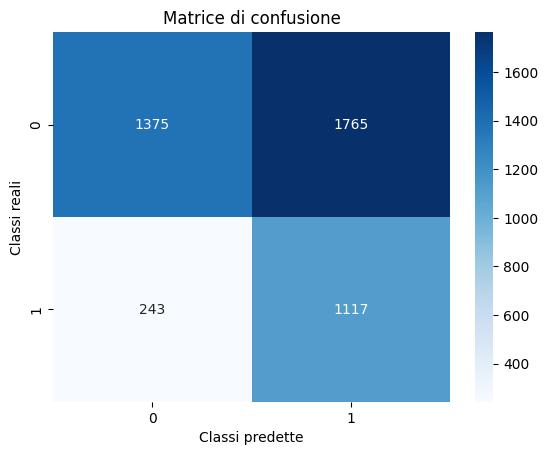

In [34]:
df =pd.read_csv("aids_clean.csv")
df = df.drop(columns=['hemo','drugs'])
df.head()

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=56)

best_params = {
    'objective':'binary:logistic',
    'subsample': 0.6, 
    'scale_pos_weight': 4, 
    'reg_lambda': 5, 
    'reg_alpha': 5, 
    'min_child_weight': 1, 
    'max_depth': 3, 
    'gamma': 0.3, 
    'colsample_bytree': 0.8}

#fit the model on train set
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

# Predictions on  test set
y_pred = xgb_clf.predict(X_test)

#calculate the recall
recall = recall_score(y_test, y_pred)
print('recall: {0:0.4f}'.format(recall))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Classi predette')
plt.ylabel('Classi reali')
plt.title('Matrice di confusione')
plt.show()

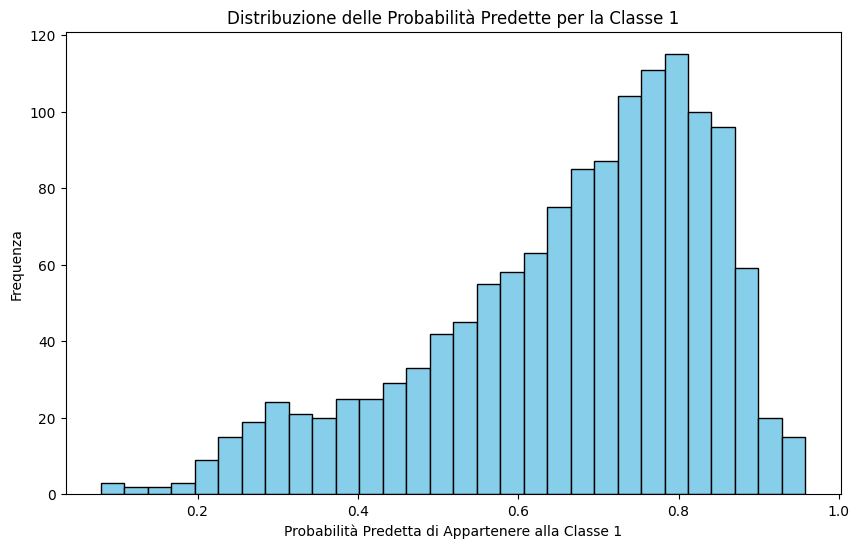

In [35]:
y_pred_pro = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva
y_pred_pro_list = y_pred_pro.tolist()

# Crea un DataFrame con y_test e y_pred_pro
df = pd.DataFrame({'y_test': y_test, 'y_pred_pro': y_pred_pro})

# Filtra e ordina
df_filtered_sorted = df[df['y_test'] == 1].sort_values(by='y_pred_pro', ascending=False)

# Crea l'istogramma
plt.figure(figsize=(10, 6))
plt.hist(df_filtered_sorted['y_pred_pro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe 1')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe 1')
plt.ylabel('Frequenza')
plt.show()

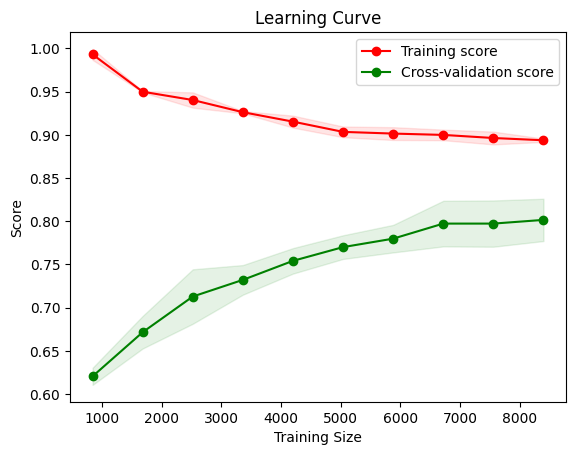

In [36]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, recall_score
train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

##### Interpretable Machine Learning methods

##### Feature importance
###### Feature importance is given as how much the variable is able not to loss any information

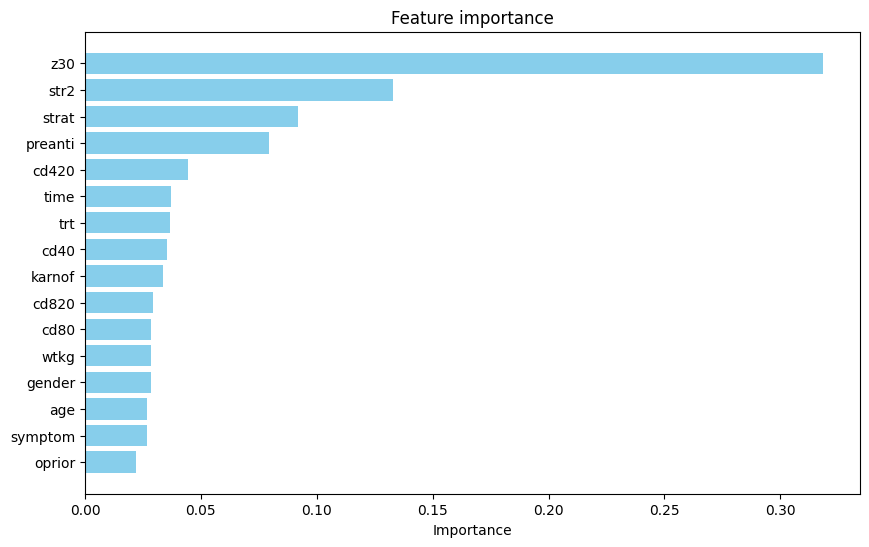

In [37]:
importance = xgb_clf.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20), color='skyblue')
plt.xlabel('Importance')
plt.title('Feature importance')
plt.gca().invert_yaxis() 
plt.show()

###### Permutation feature importance

###### Partial dependence plot

###### time, trt, age, wtkg, karnof, = the prediction range is usually between 0.5 and 0.65 (this feature is not so useful)
###### 

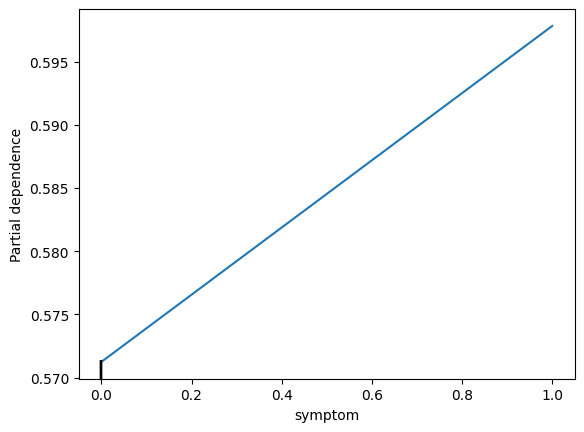

In [38]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_clf, 
                                        X_test, 
                                        ['symptom'])

###### Accumulated local efffects

PyALE._ALE_generic:INFO: Discrete feature detected.


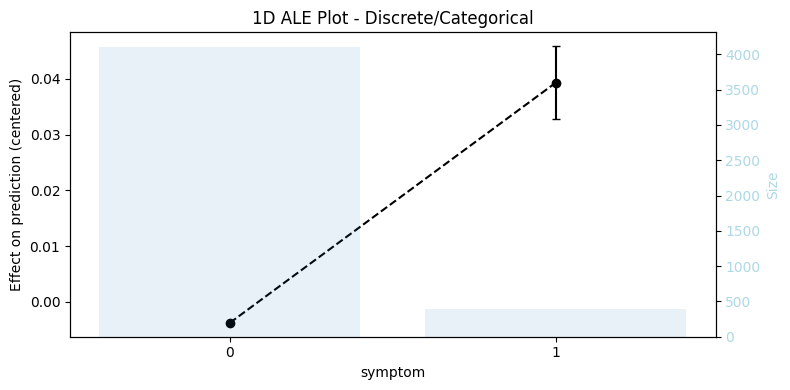

In [39]:
from PyALE import ale

features = X_test.columns.tolist()
ale_eff = ale(X = X_test[features], model = xgb_clf, feature = ['symptom'], grid_size = 50)

###### Individual conditional expectations plot

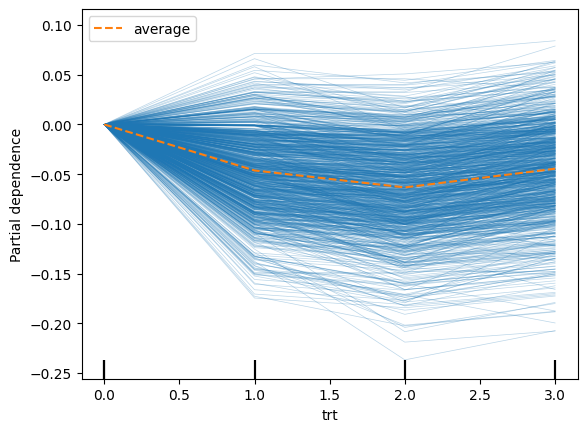

In [40]:
from sklearn.inspection import PartialDependenceDisplay

features_info = {
    "features": ["trt"],
    "kind": "both",
    "centered": True,
}
PartialDependenceDisplay.from_estimator(
    xgb_clf,
    X_test,
    **features_info
)

###### Shapley values

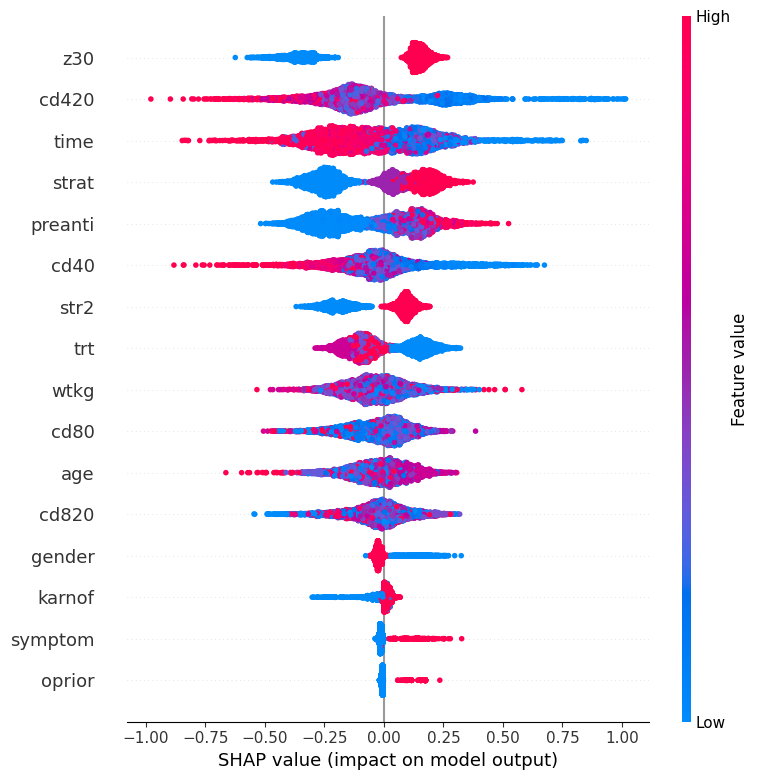

In [41]:
import shap
#Calcolo dei valori SHAP
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_test)
expected_value = explainer.expected_value #valore atteso delle previsioni del modello

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot")


In [42]:
predictions_proba = xgb_clf.predict_proba(X_test)
positive_class_proba = predictions_proba[:, 1]
# Find TP
true_positive_indices = np.where((positive_class_proba > 0.5) & (y_test == 1))[0]
print("True positives instances:")
np.set_printoptions(threshold=np.inf)
print(true_positive_indices)
print("Number of True positives: ",len(true_positive_indices))

True positives instances:
[   0    5   10   13   15   26   28   31   34   41   58   61   62   65
   66   67   68   71   73   76   82   84   87   99  100  107  112  120
  121  122  131  137  139  143  149  155  157  158  160  171  175  178
  179  181  184  196  197  198  202  203  215  217  221  223  232  233
  234  235  242  247  254  258  261  265  272  275  276  279  284  288
  293  295  300  301  303  311  314  316  318  328  333  337  338  345
  346  349  354  355  357  363  364  367  370  371  375  377  382  386
  395  402  407  410  413  418  421  425  430  432  436  447  448  451
  459  462  463  465  466  472  475  479  481  484  489  494  503  506
  509  513  517  523  536  544  546  553  562  564  565  566  568  572
  573  577  578  579  582  584  596  597  598  600  601  604  608  612
  613  628  633  636  638  641  642  646  648  655  658  659  660  661
  663  664  667  673  682  689  690  694  697  698  700  702  703  722
  736  747  750  755  757  758  760  762  768  771 

In [43]:
# Find FN
false_negatives_indices = np.where((positive_class_proba < 0.5) & (y_test == 1))[0]
print("False negatives instances:")
print(false_negatives_indices)
print("Number of False negatives: ",len(false_negatives_indices))

False negatives instances:
[   6   11   29   47   53  104  106  118  146  174  224  256  262  267
  269  305  306  313  321  323  343  352  365  373  403  406  409  419
  486  499  502  504  556  589  610  615  616  617  620  621  699  724
  744  767  783  821  828  862  881  888  897  900  912  915  936  939
  999 1004 1027 1038 1045 1058 1059 1078 1084 1092 1123 1130 1133 1139
 1140 1146 1174 1231 1253 1278 1325 1355 1424 1453 1459 1478 1479 1491
 1503 1518 1569 1591 1594 1600 1609 1610 1668 1673 1676 1705 1734 1739
 1745 1749 1755 1788 1801 1816 1817 1818 1843 1877 1880 1893 1894 1905
 1918 1935 1951 1964 1978 1999 2022 2058 2072 2074 2135 2142 2146 2154
 2164 2211 2243 2262 2314 2321 2327 2335 2349 2386 2403 2405 2436 2460
 2471 2535 2562 2565 2625 2632 2634 2661 2665 2705 2734 2743 2760 2890
 2906 2926 2929 2938 3000 3002 3079 3080 3088 3161 3198 3226 3239 3252
 3273 3281 3284 3292 3295 3344 3356 3370 3382 3383 3387 3409 3415 3455
 3480 3486 3519 3532 3535 3564 3617 3635 3660 3664

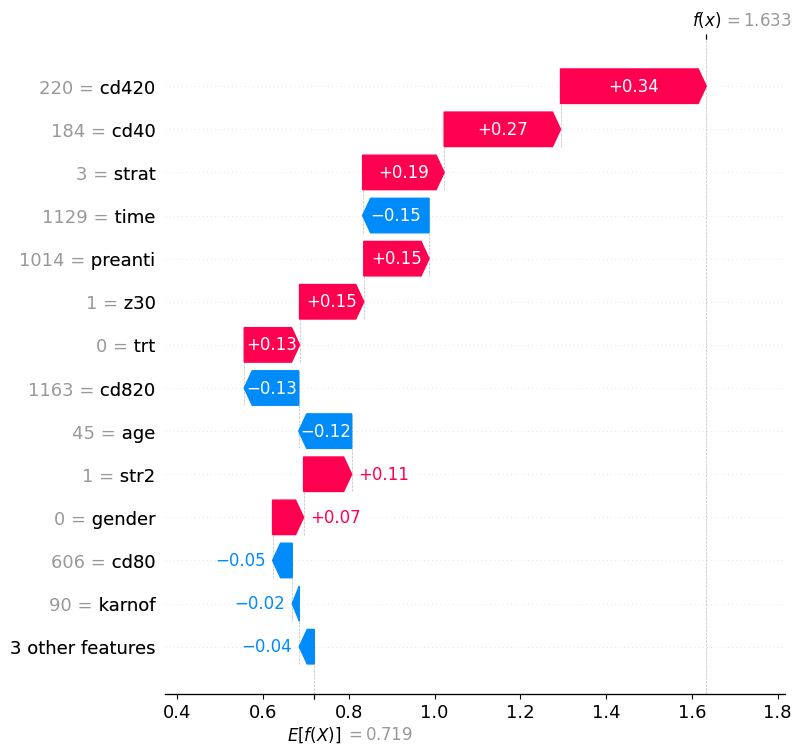

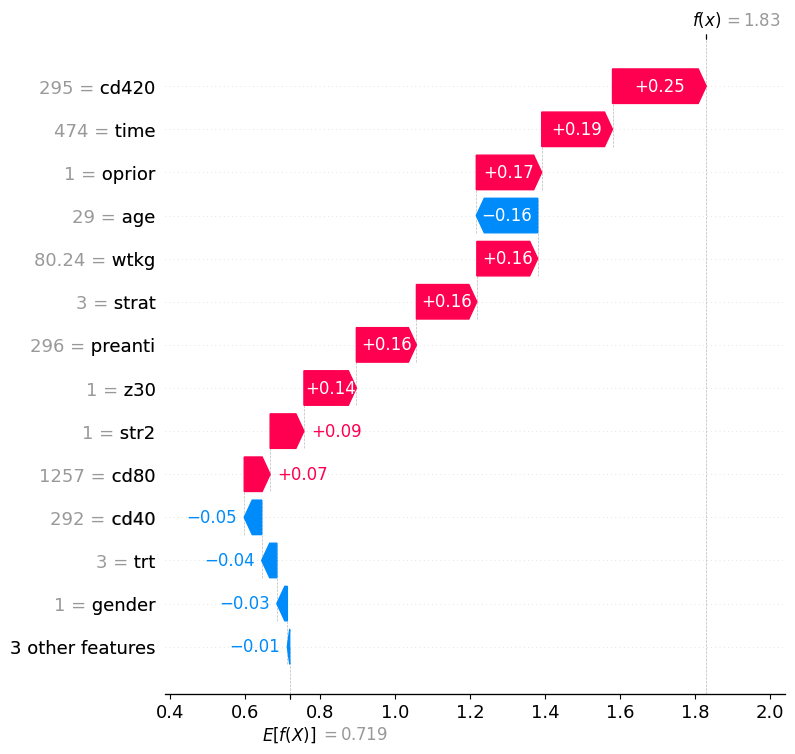

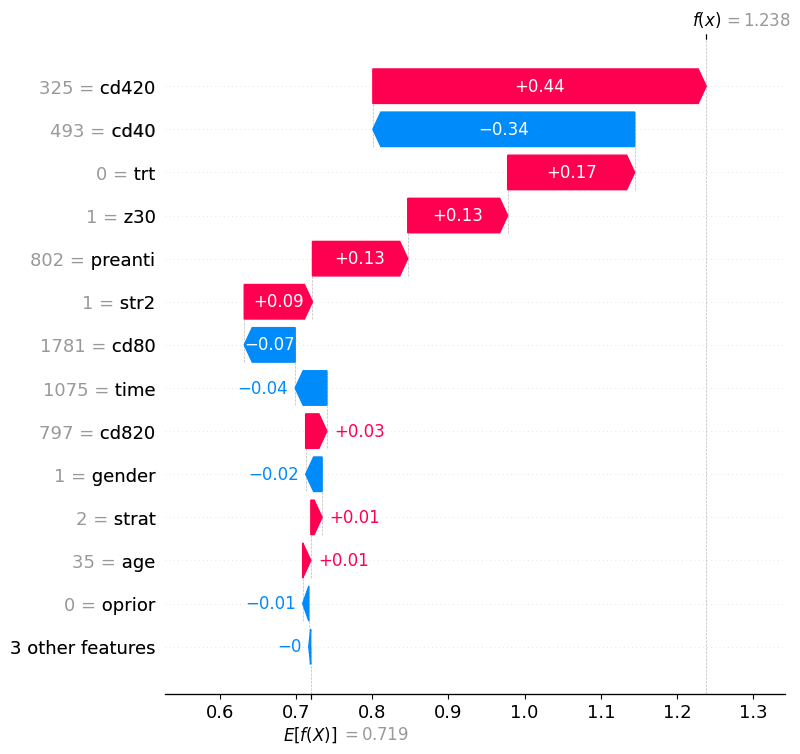

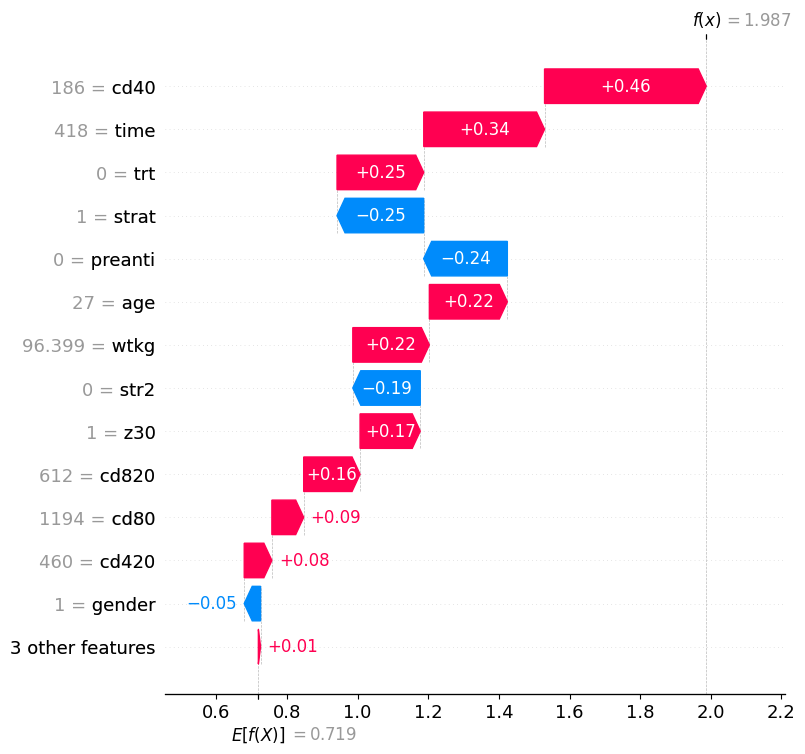

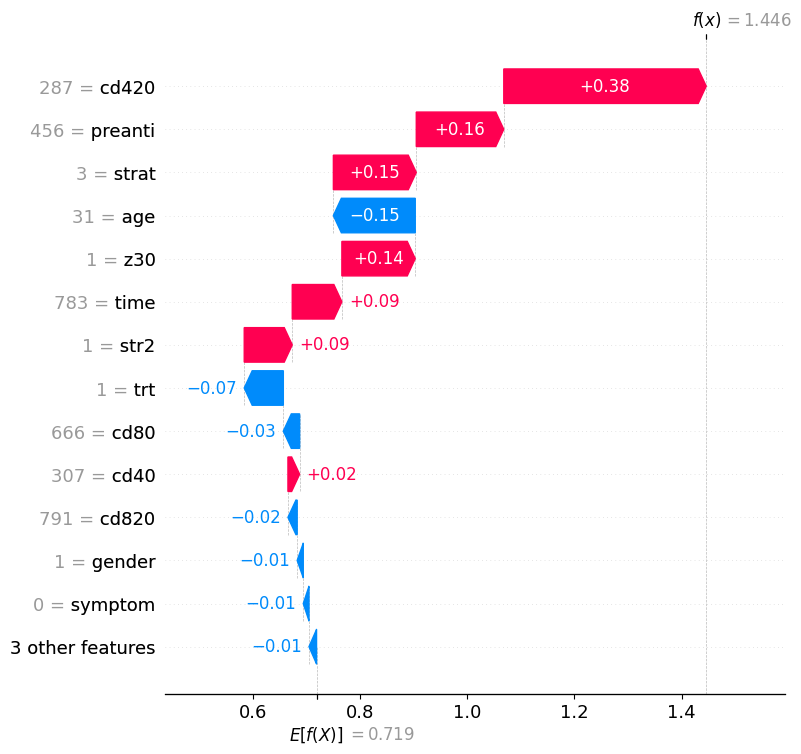

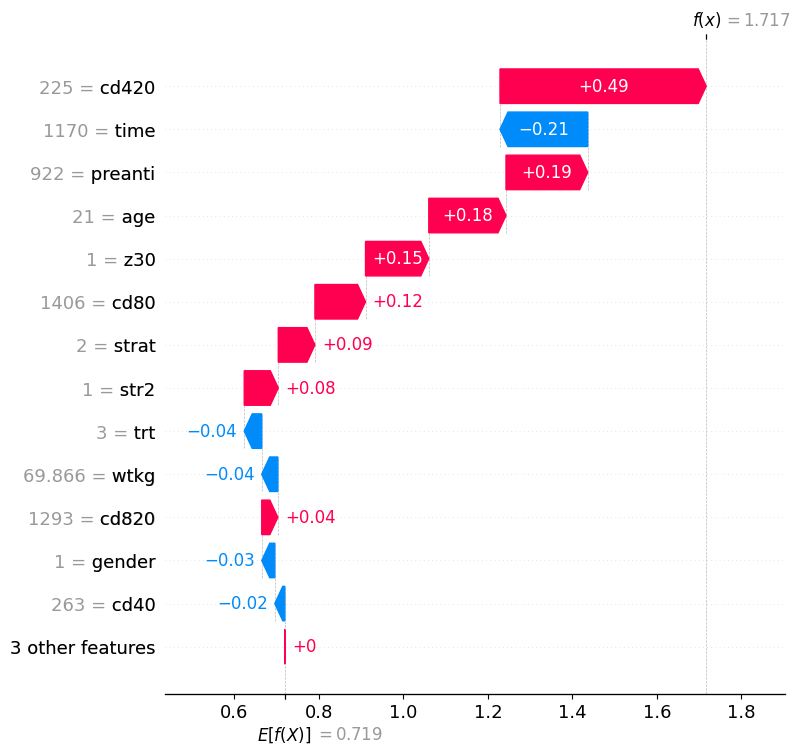

In [44]:
#TP
shap.plots.waterfall(shap_values[4333], max_display=14)
shap.plots.waterfall(shap_values[311], max_display=14)
shap.plots.waterfall(shap_values[673], max_display=14)

shap.plots.waterfall(shap_values[905], max_display=14)
shap.plots.waterfall(shap_values[407], max_display=14)
shap.plots.waterfall(shap_values[1288], max_display=14)


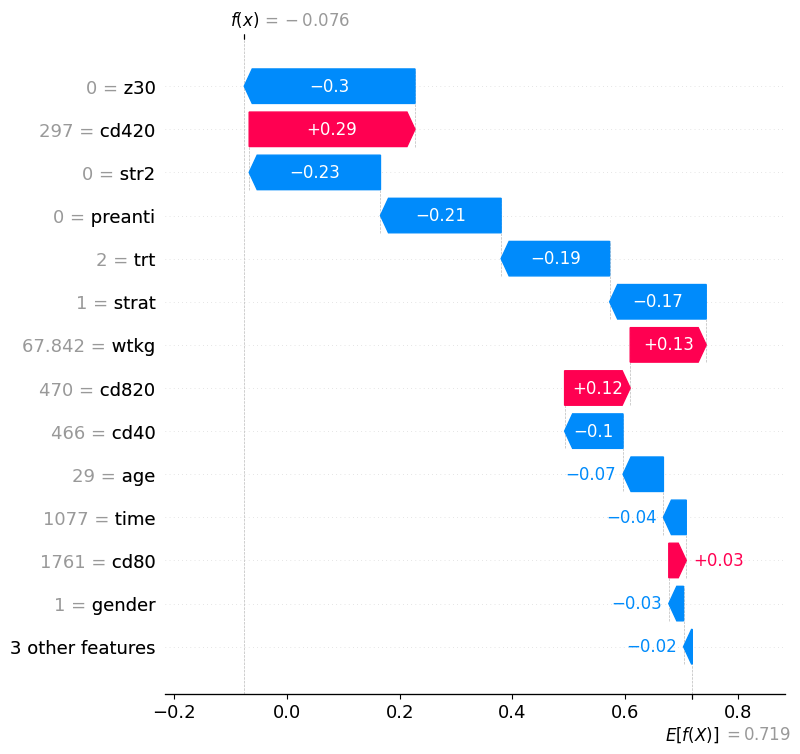

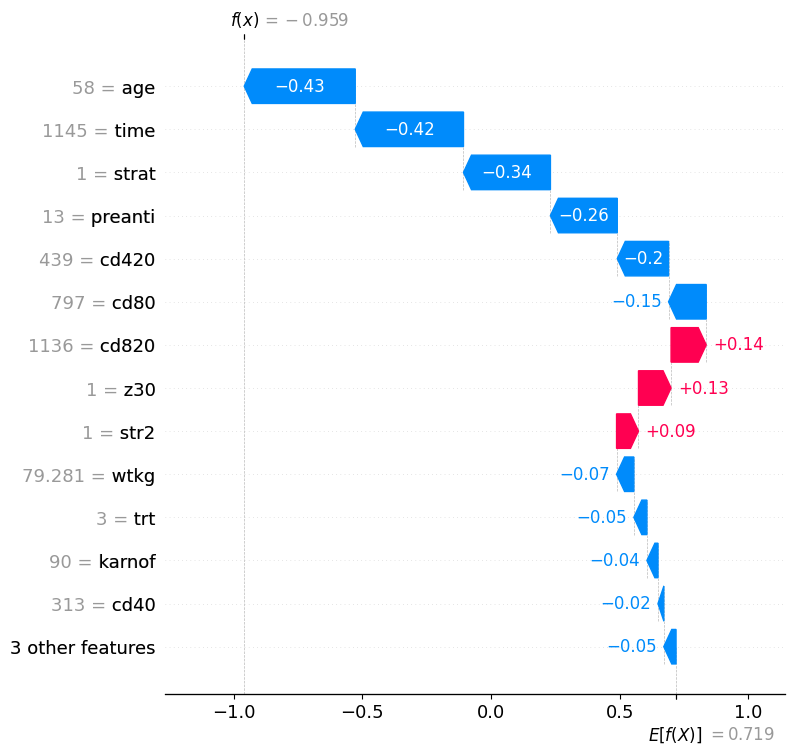

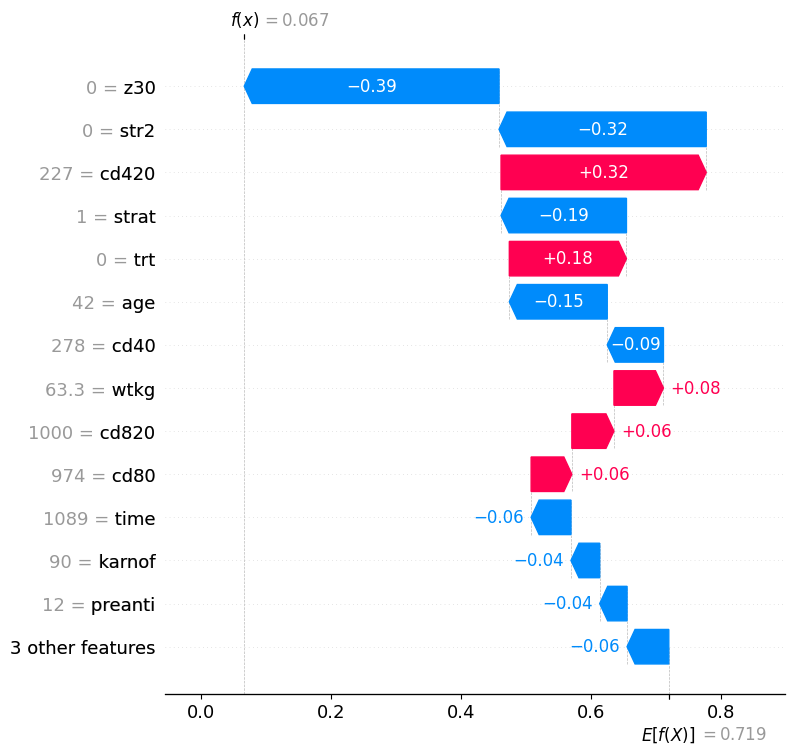

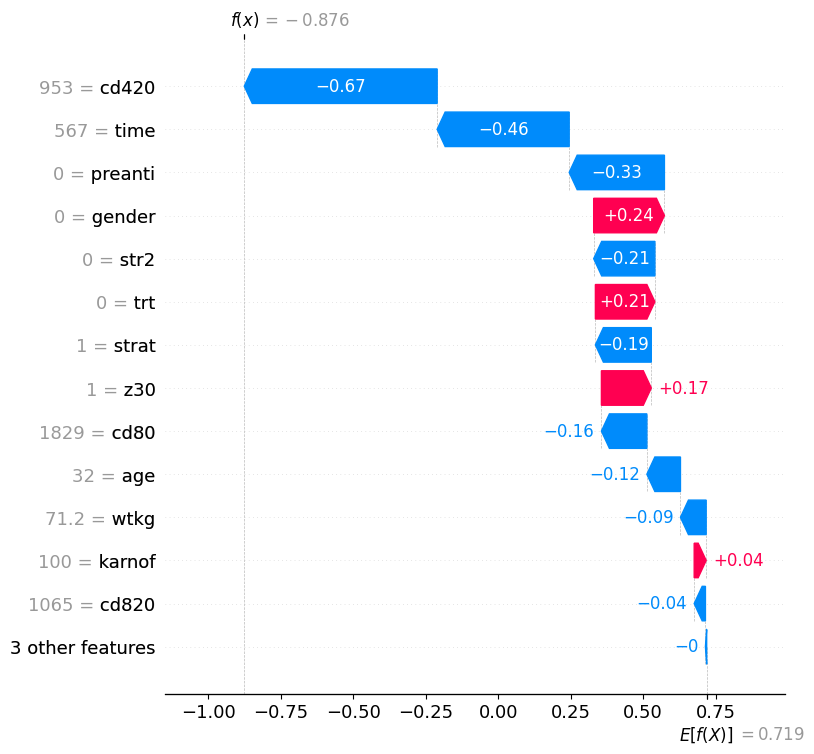

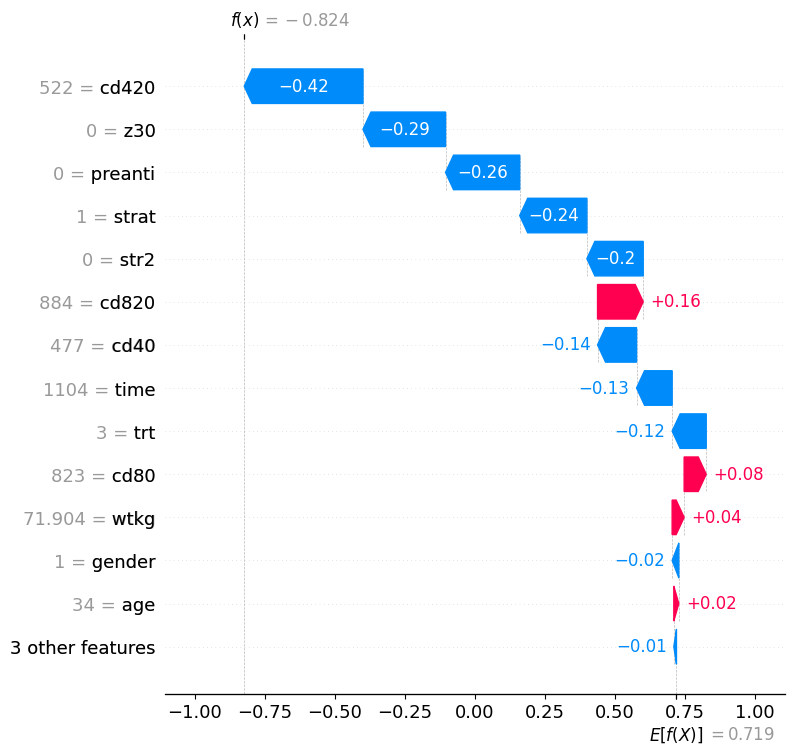

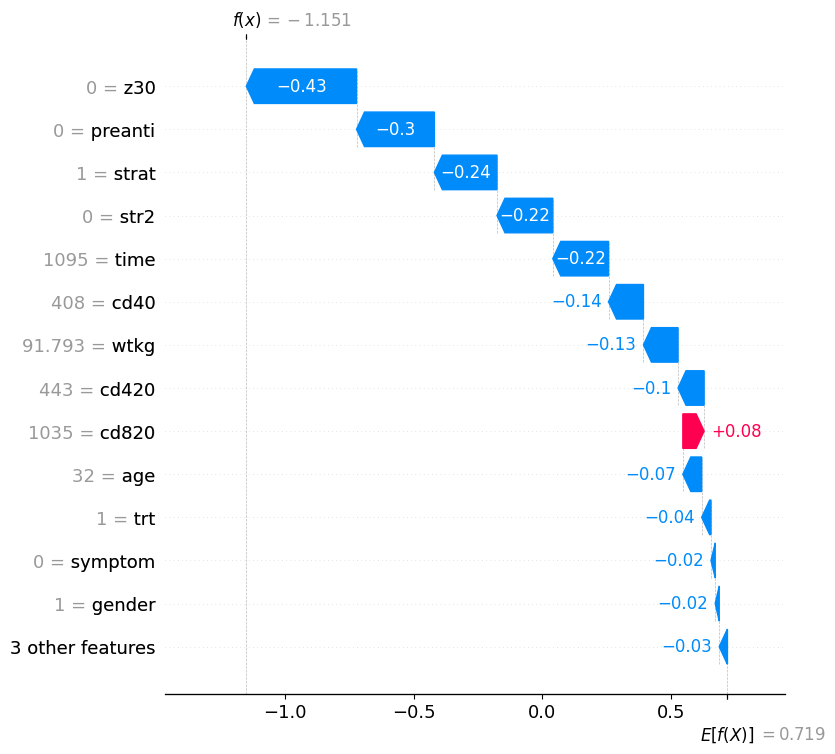

In [45]:
#FN
shap.plots.waterfall(shap_values[6], max_display=14)
shap.plots.waterfall(shap_values[53], max_display=14)
shap.plots.waterfall(shap_values[364], max_display=14)

shap.plots.waterfall(shap_values[11], max_display=14)
shap.plots.waterfall(shap_values[29], max_display=14)
shap.plots.waterfall(shap_values[352], max_display=14)




###### lime

In [46]:
import lime
from lime import lime_tabular

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=X_test.columns.tolist(),
    class_names=['not_infected', 'infected'],  # Include both classes
    verbose=True, 
    mode='classification')

In [47]:
# Explain instance using predict_proba
exp = explainer_lime.explain_instance(X_test.values[6], xgb_clf.predict_proba, num_features=10)

# Show the explanations in notebook
exp.show_in_notebook(show_table=True)

Intercept 0.7741352264541973
Prediction_local [0.38088025]
Right: 0.48098487


###### anchors

In [77]:
from anchor import anchor_tabular

def predict_labels(X):
    # Ottieni le probabilità previste per la classe positiva
    probabilities = xgb_clf.predict_proba(X)[:, 0]  # Seleziona la probabilità della classe positiva
    # Converti le probabilità in etichette binarie (1 per positivo, 0 per negativo)
    return (probabilities <= 0.5).astype(int)

feature_names = X_test.columns
class_names = [str(cls) for cls in y.unique()]

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=class_names,
    feature_names=feature_names,
    train_data=X_test.values
)


In [83]:
np.random.seed(22)
sample_to_explain = X_test.iloc[6].values
exp = explainer.explain_instance(sample_to_explain, xgb_clf.predict)

print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())
exp.show_in_notebook()

Precision: 0.96
Coverage: 0.06


#### Analyze False negatives

In [ ]:
indices = [
    6, 11, 29, 47, 53, 104, 106, 118, 146, 174, 224, 256, 262, 267,
    269, 305, 306, 313, 321, 323, 343, 352, 365, 373, 403, 406, 409, 419,
    486, 499, 502, 504, 556, 589, 610, 615, 616, 617, 620, 621, 699, 724,
    744, 767, 783, 821, 828, 862, 881, 888, 897, 900, 912, 915, 936, 939,
    999, 1004, 1027, 1038, 1045, 1058, 1059, 1078, 1084, 1092, 1123, 1130,
    1133, 1139, 1140, 1146, 1174, 1231, 1253, 1278, 1325, 1355, 1424, 1453,
    1459, 1478, 1479, 1491, 1503, 1518, 1569, 1591, 1594, 1600, 1609, 1610,
    1668, 1673, 1676, 1705, 1734, 1739, 1745, 1749, 1755, 1788, 1801, 1816,
    1817, 1818, 1843, 1877, 1880, 1893, 1894, 1905, 1918, 1935, 1951, 1964,
    1978, 1999, 2022, 2058, 2072, 2074, 2135, 2142, 2146, 2154, 2164, 2211,
    2243, 2262, 2314, 2321, 2327, 2335, 2349, 2386, 2403, 2405, 2436, 2460,
    2471, 2535, 2562, 2565, 2625, 2632, 2634, 2661, 2665, 2705, 2734, 2743,
    2760, 2890, 2906, 2926, 2929, 2938, 3000, 3002, 3079, 3080, 3088, 3161,
    3198, 3226, 3239, 3252, 3273, 3281, 3284, 3292, 3295, 3344, 3356, 3370,
    3382, 3383, 3387, 3409, 3415, 3455, 3480, 3486, 3519, 3532, 3535, 3564,
    3617, 3635, 3660, 3664, 3665, 3683, 3747, 3755, 3765, 3770, 3780, 3786,
    3807, 3810, 3812, 3835, 3869, 3898, 3903, 3907, 3938, 3962, 3980, 3993,
    4012, 4013, 4026, 4029, 4053, 4086, 4092, 4107, 4115, 4129, 4155, 4171,
    4189, 4203, 4206, 4266, 4301, 4329, 4342, 4347, 4357, 4368, 4378, 4403,
    4409, 4415, 4434, 4443, 4457, 4467, 4476
]

indices_1 = [ 
    6, 11, 53, 104, 106, 146, 174, 224, 262, 267, 305, 306, 
    313, 343, 409, 419, 502, 556, 610, 616, 620, 744, 783, 
    881, 915, 1038, 1045, 1058, 1059, 1078, 1084, 1123, 1139, 
    1231, 1278, 1325, 1424, 1459, 1478, 1479, 1569, 1594, 1668, 
    1734, 1739, 1788, 1816, 1817, 1843, 1877, 1880, 1893, 1918, 
    1978, 1999, 2072, 2074, 2135, 2154, 2164, 2243, 2262, 2321, 
    2349, 2386, 2405, 2436, 2460, 2471, 2535, 2565, 2632, 2634, 
    2661, 2705, 2743, 2906, 2926, 2929, 3000, 3002, 3079, 3252, 
    3344, 3356, 3370, 3387, 3409, 3415, 3455, 3564, 3617, 3664, 
    3665, 3683, 3765, 3780, 3786, 3980, 3993, 4029, 4053, 4107, 
    4206, 4266, 4342, 4347, 4457
    ]

for idx in indices_1:
    shap.plots.waterfall(shap_values[idx], max_display=14)


In [ ]:
indices_2 = [
    256, 365, 486, 699, 1133, 1453, 1518, 1591, 1749, 
    1801, 1818, 2058, 2142, 2146, 2665, 3281, 3284, 3295, 
    3382, 3519, 3535, 3755, 3835, 3962, 4026, 4171, 4329, 
    4357, 4378, 4434, 4476
]

for idx in indices_2:
    xplainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=X_test.columns.tolist(),
    class_names=['not_infected', 'infected'],  # Include both classes
    verbose=True, 
    mode='classification')
    
    # Explain instance using predict_proba
    exp = explainer_lime.explain_instance(X_test.values[idx], xgb_clf.predict_proba, num_features=10)

    # Show the explanations in notebook
    exp.show_in_notebook(show_table=True)

In [ ]:
indices_3 = [
    29, 47, 118, 269, 321, 323, 352, 373, 403, 406, 499, 504, 
    589, 615, 617, 621, 724, 767, 821, 828, 862, 888, 897, 900, 
    912, 936, 939, 999, 1004, 1027, 1092, 1130, 1140, 1146, 1174, 
    1253, 1355, 1491, 1503, 1600, 1609, 1610, 1673, 1676, 1705, 
    1745, 1755, 1817, 1894, 1905, 1935, 1951, 1964, 2022, 2072, 
    2135, 2314, 2327, 2335, 2403, 2562, 2625, 2734, 2760, 2890, 
    2938, 3080, 3088, 3161, 3198, 3226, 3239, 3273, 3292, 3383, 
    3532, 3635, 3660, 3747, 3770, 3807, 3810, 3812, 3869, 3898, 
    3903, 3907, 3938, 4012, 4013, 4086, 4092, 4115, 4129, 4155, 
    4189, 4203, 4301, 4368, 4403, 4409, 4415, 4443, 4467
]

